# Analysis and Modelling

The objective of this notebook is to carry out the exploration of different modeling methods, which will allow us to observe which one best adapts to our data and its hyperparameters.

The first thing we will do is to test the different models and calculate the hyperparameters that best fit our dataset. For this we will model with the example csv `taxi_model_sample001.csv` obtained in the notebook `final_eda.ipynb`.

Once we have chosen the model and the hyperparameters we will model with the complete csv `taxi_model.csv` in the notebook `final_model.ipynb`.

## Chicago Coordinates 
-87.6244212, 41.8755616

## 1 Load the libraries

In [1]:
# We load the libraries we are going to use in our analysis

# Libraries to manage our dataset
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
import matplotlib.pyplot as plt
pd.options.display.max_columns = None

# Libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor

# A library that will allow us to measure how good our model is.
from sklearn.metrics import mean_squared_error

## 2 Read the data

In this section we are going to load our sample dataset and we are going to divide it in train, validation and test. While train and validation will use it to get the best model, the test will save it to finally check how good is the model created.

### 2.1 We load csv example

In [2]:
chicago_trips = pd.read_csv('../Data/taxi_model_sample001.csv')

### 2.2 We check that it has been loaded correctly

In [3]:
chicago_trips.sample(5)

,trip_id,trip_seconds,pickup_community_area,dropoff_community_area,fare,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,year,month,day,week_day,hour,minute,distance_miles,distance_ord,distance_mdw,taxi_id_ind,payment_type_ind
269236,48fb602fbf334acba0ad4e230fb026d8a5cda11c,600,32,33,10.00,Cash,Dispatch Taxi Affiliation,41.884987,-87.620993,41.849247,-87.624135,71.0,1017.0,298.1500,few clouds,252.0,3.0,2016,6,20,2,9,30,2.477602,20.663214,9.891721,116,0
144557,7fbbfdce8c21504e347dba7d9086a8a91c46e9ba,600,32,32,7.05,Credit Card,Taxi Affiliation Services,41.884987,-87.620993,41.880994,-87.632746,90.0,1035.0,266.2795,snow,157.0,4.0,2015,3,3,3,9,30,0.858484,19.983967,10.561540,693,1
179179,4cf5ae684936a5af64c9fe207aeaa1be2e89c0c2,900,7,77,10.65,Cash,Dispatch Taxi Affiliation,41.922686,-87.649489,41.986712,-87.663416,93.0,1026.0,293.9540,sky is clear,37.0,3.0,2014,8,18,2,0,45,4.525012,16.700655,11.820235,1185,0
251340,e357e21ce9b5a4784328a053c366dbe09a855c26,480,8,32,6.85,Credit Card,Dispatch Taxi Affiliation,41.892042,-87.631864,41.870607,-87.622173,68.0,1021.0,291.8300,scattered clouds,70.0,6.0,2015,10,7,4,21,45,1.624888,19.797888,10.738379,363,1
135207,6f9ef1b512678f4de3ea4c714cc692dbe1e36bd0,360,8,28,5.65,Cash,Northwest Management LLC,41.893216,-87.637844,41.885300,-87.642808,86.0,1027.0,290.0765,light rain,211.0,2.0,2015,6,15,2,9,45,0.645561,19.228525,10.221773,325,0


In [4]:
chicago_trips.dtypes

trip_id                        object
trip_seconds                    int64
pickup_community_area           int64
dropoff_community_area          int64
fare                          float64
payment_type                   object
company                        object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
humidity                      float64
pressure                      float64
temperature                   float64
weather_description            object
wind_direction                float64
wind_speed                    float64
year                            int64
month                           int64
day                             int64
week_day                        int64
hour                            int64
minute                          int64
distance_miles                float64
distance_ord                  float64
distance_mdw                  float64
taxi_id_ind 

### 2.3 We eliminate the feautures that are not useful

In [5]:
chicago_trips = chicago_trips.drop(['trip_id','trip_seconds','taxi_id_ind','payment_type_ind'],axis=1)

In [6]:
chicago_trips.dtypes

pickup_community_area           int64
dropoff_community_area          int64
fare                          float64
payment_type                   object
company                        object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
humidity                      float64
pressure                      float64
temperature                   float64
weather_description            object
wind_direction                float64
wind_speed                    float64
year                            int64
month                           int64
day                             int64
week_day                        int64
hour                            int64
minute                          int64
distance_miles                float64
distance_ord                  float64
distance_mdw                  float64
dtype: object

### 2.4 We convert string variables to dummies

In [7]:
chicago_trips = pd.get_dummies(chicago_trips)

### 2.5 We divide our dataset into train, validation and test

We do not do cross validation because it would not make sense to use 2017 data to predict 2015.

#### 2.5.1 Train data

In [8]:
chicago_train = chicago_trips[(chicago_trips['year']<2016) |
                             ((chicago_trips['year']==2016) & (chicago_trips['month']<=1))]

In [9]:
chicago_train.shape

(207004, 170)

In [10]:
train_target = np.ravel(chicago_train[['fare']])
train_predictors = chicago_train.drop(['fare'],axis=1)

#### 2.5.2 Validation and Test data

In [11]:
chicago_test_val = chicago_trips[(chicago_trips['year']==2017) |
                             ((chicago_trips['year']==2016) & (chicago_trips['month']>1))]

In [12]:
chicago_test_val.shape

(74806, 170)

In [13]:
chicago_test_val_target = np.ravel(chicago_test_val[['fare']])
chicago_test_val_predictors = chicago_test_val.drop(['fare'],axis=1)

In [14]:
# We get the validation and test data
validation_predictors,test_predictors, validation_target, test_target = train_test_split(chicago_test_val_predictors, 
                                                                                         chicago_test_val_target, 
                                                                                         test_size=0.38, 
                                                                                         random_state=42)


In [15]:
# We erase disk memory space
del chicago_test_val, chicago_test_val_predictors, chicago_test_val_target, chicago_train, chicago_trips

### 2.6 We create the function that will allow us to measure how good our model is

In [16]:
def rmse(target,predictors):
    return sqrt(mean_squared_error(target, predictors))

## 3 Check the best model and depth

In this section we are going to test different models and obtain the optimum depth for this model assigning to all models 100 estimators.

### 3.1 DECISION TREE

#### 3.1.1 Check the model

In [17]:
%%time
dicc_dt={}
for depth in range(2,18):
    print('Depth: %d' % (depth))
    
    # We train the model
    taxi_model_dt = DecisionTreeRegressor(max_depth=depth,random_state=13)
    
    # We fit the model
    taxi_model_dt.fit(train_predictors, train_target)
    
    # We predict train and validation
    train_predictions = taxi_model_dt.predict(train_predictors)
    val_predictions = taxi_model_dt.predict(validation_predictors)
    
    # We get the errors
    error_train = rmse(train_target, train_predictions)
    error_val = rmse(validation_target, val_predictions)
    difference = error_val - error_train
    
    # We save the errors and the difference in a dictionary
    dicc_dt[str(depth)]= [error_train,error_val,difference]
    print ('For a %d depth the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
               % (depth,error_train,error_val,difference)) 

Depth: 2
For a 2 depth the RMSE_train is 3.22321 $, the RMSE_val is 4.61579 $ and the difference 1.39257 $
Depth: 3
For a 3 depth the RMSE_train is 2.77754 $, the RMSE_val is 4.19796 $ and the difference 1.42042 $
Depth: 4
For a 4 depth the RMSE_train is 2.53839 $, the RMSE_val is 4.04359 $ and the difference 1.50520 $
Depth: 5
For a 5 depth the RMSE_train is 2.40275 $, the RMSE_val is 3.14695 $ and the difference 0.74420 $
Depth: 6
For a 6 depth the RMSE_train is 2.33466 $, the RMSE_val is 3.05898 $ and the difference 0.72431 $
Depth: 7
For a 7 depth the RMSE_train is 2.27349 $, the RMSE_val is 3.00672 $ and the difference 0.73323 $
Depth: 8
For a 8 depth the RMSE_train is 2.22661 $, the RMSE_val is 2.80826 $ and the difference 0.58164 $
Depth: 9
For a 9 depth the RMSE_train is 2.17460 $, the RMSE_val is 2.89294 $ and the difference 0.71834 $
Depth: 10
For a 10 depth the RMSE_train is 2.10985 $, the RMSE_val is 2.97511 $ and the difference 0.86526 $
Depth: 11
For a 11 depth the RMSE_t

#### 3.1.2 Check the best depth 

In [18]:
# Best depth based on minimum error based on train data
min(dicc_dt.items(), key=lambda x: x[1][0])

('17', [1.521356654005601, 3.407332838434179, 1.8859761844285778])

In [19]:
# Best depth based on minimum error based on validation data
min(dicc_dt.items(), key=lambda x: x[1][1])

('8', [2.2266113736261373, 2.8082554364183983, 0.581644062792261])

In [20]:
# Best depth based on difference of errors
min(dicc_dt.items(), key=lambda x: x[1][2])

('8', [2.2266113736261373, 2.8082554364183983, 0.581644062792261])

#### 3.1.3 Plot the errors and difference on the basis of the depth

In [21]:
# We convert the dictionary to Dataframe
dt_df = pd.DataFrame.from_dict(dicc_dt).T
dt_df.columns=['error_train','error_val','difference']
dt_df

,error_train,error_val,difference
2,3.223212,4.615786,1.392574
3,2.777536,4.197956,1.420420
4,2.538392,4.043590,1.505198
5,2.402749,3.146945,0.744197
6,2.334665,3.058977,0.724312
7,2.273489,3.006716,0.733227
8,2.226611,2.808255,0.581644
9,2.174600,2.892939,0.718340
10,2.109846,2.975109,0.865263
11,2.048765,3.151190,1.102425


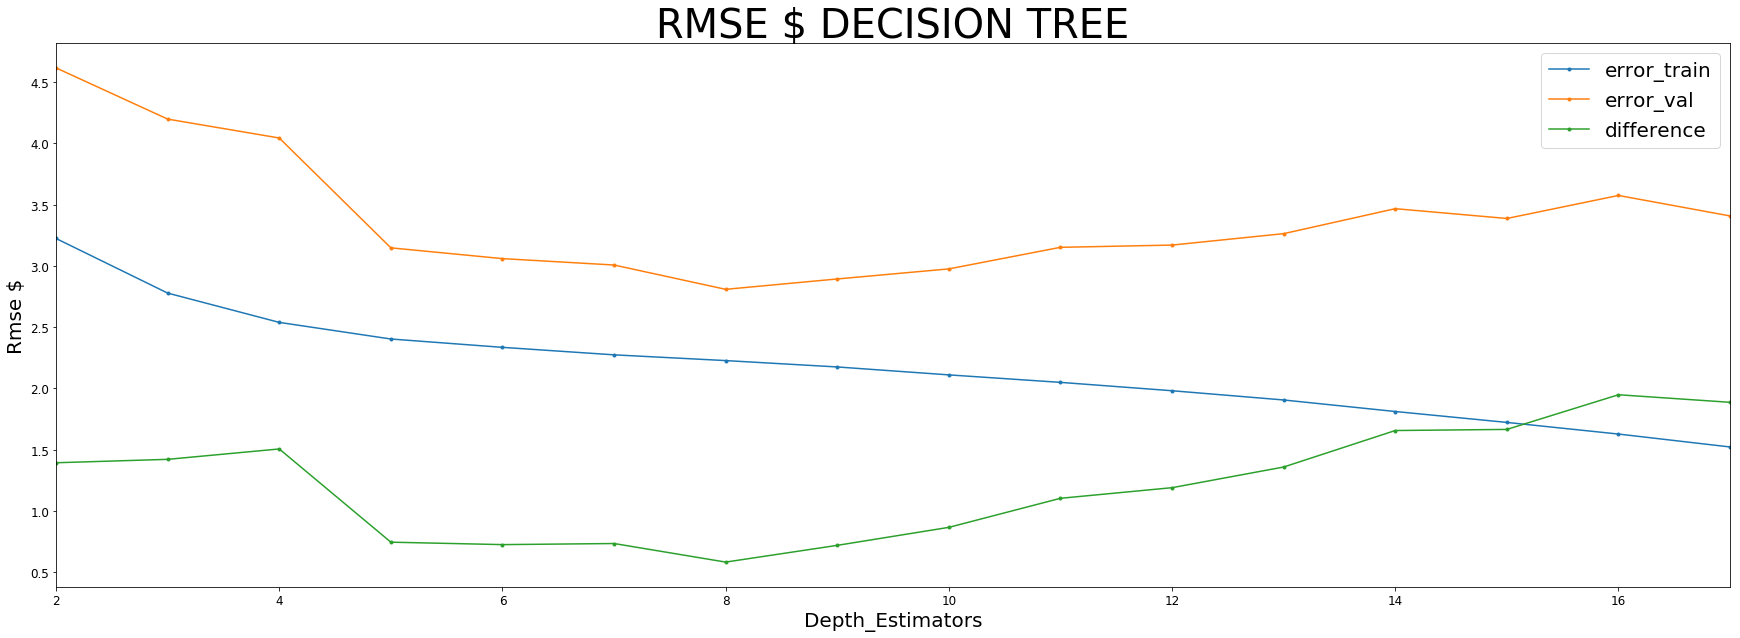

In [22]:
# We plot the results
ax = dt_df.plot(kind='line', style='.-',figsize=(30, 10),fontsize=14 , rot=0)
ax.set_title('RMSE $ DECISION TREE', fontsize=40)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

The optimum depth for a decision tree would be 8 based on the validation error and the difference between errors.

### 3.2 RANDOM FOREST

#### 3.2.1 Check the model

In [23]:
%%time
dicc_rf={}
estimator = 100
for depth in range(2,18):
    print('Depth: %d' % (depth))
    
    # We train the model
    taxi_model_rf = RandomForestRegressor(max_depth=depth,
                                          n_estimators=estimator,
                                          n_jobs=-1,
                                          random_state=13)
    
    # We fit the model
    taxi_model_rf.fit(train_predictors, train_target)                                    
    
    # We predict train and validation
    train_predictions = taxi_model_rf.predict(train_predictors)
    val_predictions = taxi_model_rf.predict(validation_predictors)
    
    # We get the errors
    error_train = rmse(train_target, train_predictions)
    error_val = rmse(validation_target, val_predictions)
    difference = error_val - error_train
    
    # We save the errors and the difference in a dictionary
    dicc_rf[str(depth)]= [error_train,error_val,difference]
    print ('For a %d depth and %d estimators the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
               % (depth,estimator,error_train,error_val,difference))  
            

Depth: 2
For a 2 depth and 100 estimators the RMSE_train is 3.20478 $, the RMSE_val is 4.60455 $ and the difference 1.39978 $
Depth: 3
For a 3 depth and 100 estimators the RMSE_train is 2.73840 $, the RMSE_val is 4.18866 $ and the difference 1.45026 $
Depth: 4
For a 4 depth and 100 estimators the RMSE_train is 2.50335 $, the RMSE_val is 4.01478 $ and the difference 1.51142 $
Depth: 5
For a 5 depth and 100 estimators the RMSE_train is 2.38181 $, the RMSE_val is 3.25319 $ and the difference 0.87138 $
Depth: 6
For a 6 depth and 100 estimators the RMSE_train is 2.30750 $, the RMSE_val is 3.04712 $ and the difference 0.73963 $
Depth: 7
For a 7 depth and 100 estimators the RMSE_train is 2.24550 $, the RMSE_val is 2.94136 $ and the difference 0.69586 $
Depth: 8
For a 8 depth and 100 estimators the RMSE_train is 2.19016 $, the RMSE_val is 2.83719 $ and the difference 0.64703 $
Depth: 9
For a 9 depth and 100 estimators the RMSE_train is 2.13232 $, the RMSE_val is 2.77163 $ and the difference 0.

#### 3.2.2 Check the best depth 

In [24]:
# Best depth based on minimum error based on train data
min(dicc_rf.items(), key=lambda x: x[1][0])

('17', [1.5185552894897398, 2.6733037794813064, 1.1547484899915665])

In [25]:
# Best depth based on minimum error based on validation data
min(dicc_rf.items(), key=lambda x: x[1][1])

('15', [1.6911342498724955, 2.670621024359623, 0.9794867744871274])

In [26]:
# Best depth based on difference of errors
min(dicc_rf.items(), key=lambda x: x[1][2])

('9', [2.132321910177741, 2.771625067944318, 0.6393031577665771])

#### 3.2.3 Plot the errors and difference on the basis of the depth

In [27]:
# We convert the dictionary to Dataframe
rf_df = pd.DataFrame.from_dict(dicc_rf).T
rf_df.columns=['error_train','error_val','difference']
rf_df

,error_train,error_val,difference
2,3.204778,4.604553,1.399775
3,2.738396,4.188659,1.450263
4,2.503355,4.014779,1.511425
5,2.381809,3.253193,0.871384
6,2.307495,3.047124,0.739628
7,2.245502,2.941362,0.695860
8,2.190159,2.837193,0.647034
9,2.132322,2.771625,0.639303
10,2.069556,2.727421,0.657865
11,2.003661,2.705087,0.701427


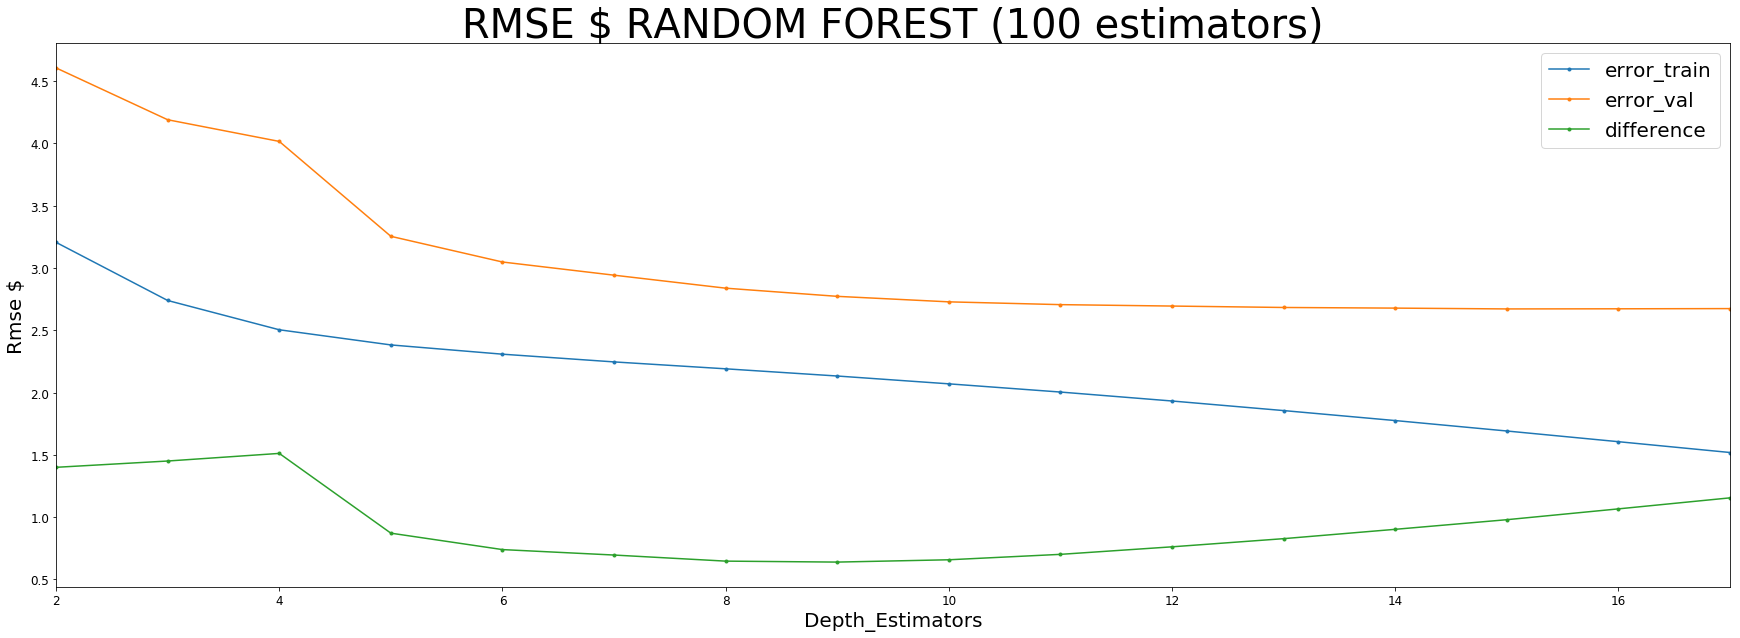

In [28]:
# We plot the results
ax = rf_df.plot(kind='line', style='.-',figsize=(30, 10),fontsize=14, rot=0)
ax.set_title('RMSE $ RANDOM FOREST (100 estimators)', fontsize=40)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

The optimum depth for a random forest would be 9 based on the the difference between errors because for more depth the validation error keeps going down and never reaches a minimum which would cause overfitting.

### 3.3 XGBOOST

#### 3.3.1 Check the model

In [29]:
%%time
dicc_xgb={}
estimator = 100
for depth in range(2,18):
    print('Depth: %d' % (depth))
    
    # We train the model
    taxi_model_xgb = XGBRegressor(max_depth=depth,
                                  learning_rate=0.05,
                                  n_estimators=estimator,
                                  n_jobs=-1,
                                  seed=13)
    
    # We fit the model
    taxi_model_xgb.fit(train_predictors,
                       train_target,
                       early_stopping_rounds=5,
                       eval_set=[(validation_predictors, validation_target)],
                       verbose=False)
    
    # We predict train and validation
    train_predictions = taxi_model_xgb.predict(train_predictors)
    val_predictions = taxi_model_xgb.predict(validation_predictors)
    
    # We get the errors
    error_train = rmse(train_target, train_predictions)
    error_val = rmse(validation_target, val_predictions)
    difference = error_val - error_train
    
    # We save the errors and the difference in a dictionary
    dicc_xgb[str(depth) + '_' + str(estimator)]= [error_train,error_val,difference]
    print ('For a %d depth and %d estimators the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
               % (depth,estimator, error_train,error_val,difference))
    

Depth: 2
For a 2 depth and 100 estimators the RMSE_train is 2.46565 $, the RMSE_val is 3.36767 $ and the difference 0.90201 $
Depth: 3
For a 3 depth and 100 estimators the RMSE_train is 2.32672 $, the RMSE_val is 2.85943 $ and the difference 0.53270 $
Depth: 4
For a 4 depth and 100 estimators the RMSE_train is 2.25353 $, the RMSE_val is 2.70142 $ and the difference 0.44789 $
Depth: 5
For a 5 depth and 100 estimators the RMSE_train is 2.19358 $, the RMSE_val is 2.62989 $ and the difference 0.43631 $
Depth: 6
For a 6 depth and 100 estimators the RMSE_train is 2.13933 $, the RMSE_val is 2.59465 $ and the difference 0.45532 $
Depth: 7
For a 7 depth and 100 estimators the RMSE_train is 2.07856 $, the RMSE_val is 2.57736 $ and the difference 0.49880 $
Depth: 8
For a 8 depth and 100 estimators the RMSE_train is 2.01613 $, the RMSE_val is 2.60245 $ and the difference 0.58632 $
Depth: 9
For a 9 depth and 100 estimators the RMSE_train is 1.94378 $, the RMSE_val is 2.62289 $ and the difference 0.

#### 3.3.2 Check the best depth 

In [30]:
# Best depth based on minimum error based on train data
min(dicc_xgb.items(), key=lambda x: x[1][0])

('17_100', [1.0798698119961578, 2.8424070885176094, 1.7625372765214515])

In [31]:
# Best depth based on minimum error based on validation data
min(dicc_xgb.items(), key=lambda x: x[1][1])

('7_100', [2.0785568599792663, 2.577359560367112, 0.49880270038784547])

In [32]:
# Best depth based on difference of errors
min(dicc_xgb.items(), key=lambda x: x[1][2])

('5_100', [2.193581188042179, 2.6298915287187574, 0.43631034067657826])

#### 3.3.3 Plot the errors and difference on the basis of the depth

In [33]:
# We convert the dictionary to Dataframe
xgb_df = pd.DataFrame.from_dict(dicc_xgb).T
xgb_df.columns=['error_train','error_val','difference']
xgb_df

,error_train,error_val,difference
2_100,2.465651,3.367665,0.902015
3_100,2.326722,2.859425,0.532703
4_100,2.253529,2.701417,0.447888
5_100,2.193581,2.629892,0.436310
6_100,2.139330,2.594650,0.455320
7_100,2.078557,2.577360,0.498803
8_100,2.016132,2.602453,0.586321
9_100,1.943776,2.622889,0.679113
10_100,1.862503,2.696314,0.833811
11_100,1.770314,2.725540,0.955227


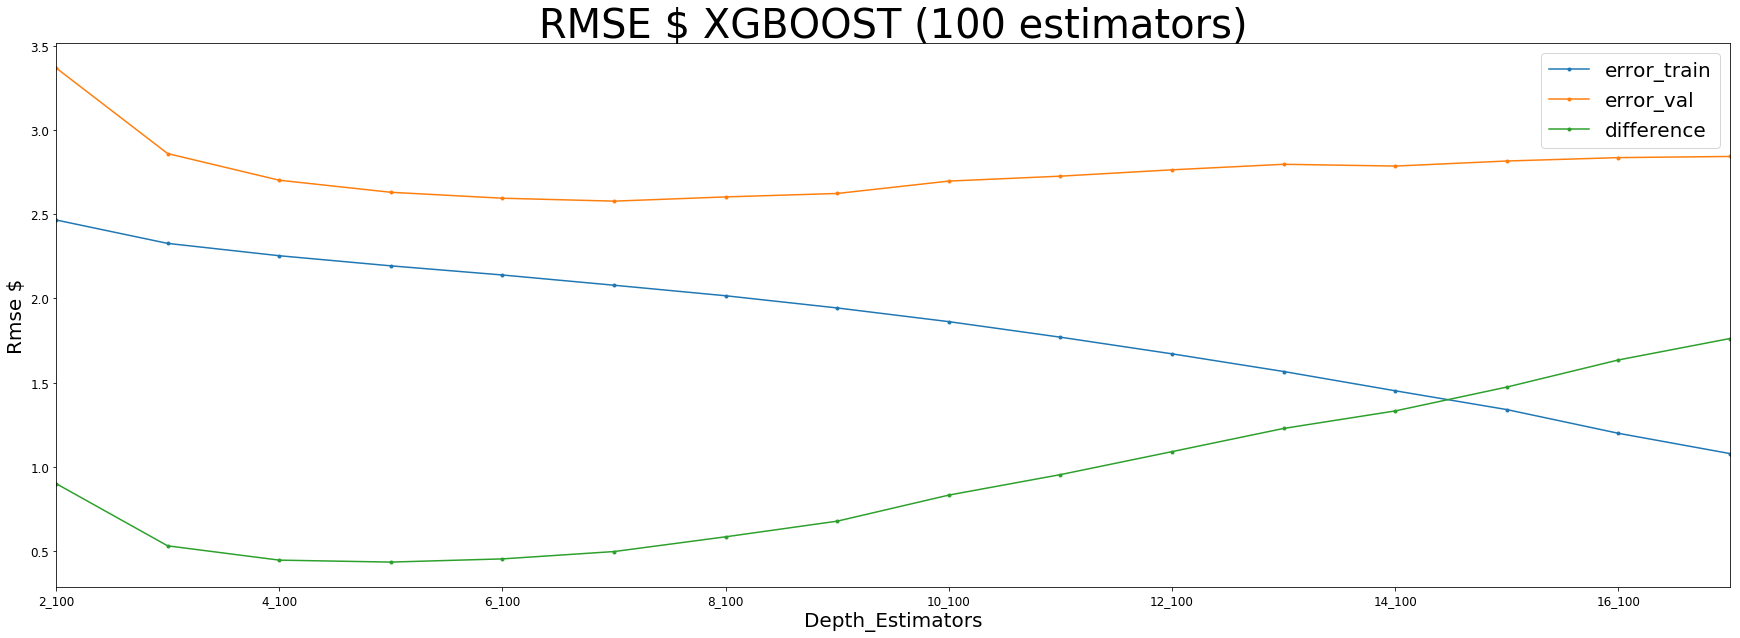

In [34]:
# We plot the results
ax = xgb_df.plot(kind='line', style='.-',figsize=(30, 10),fontsize=14, rot=0)
ax.set_title('RMSE $ XGBOOST (100 estimators)', fontsize=40)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

The optimum depth for a Xgboost would be 7 based on the validation error and the difference between errors because more depth would cause overfitting.

### 3.4 BAGGING REGRESSOR + DECISION TREE

#### 3.4.1 Check the model

In [35]:
%%time
dicc_bg={}
estimator = 100
for depth in range(2,18):
    print('Depth: %d' % (depth))    
    
    # We train the model
    taxi_model_bg= BaggingRegressor(base_estimator = DecisionTreeRegressor(max_depth=depth,
                                                                           random_state=13),
                                    n_estimators = estimator,
                                    n_jobs= -1,
                                    random_state=13)
    
    # We fit the model
    taxi_model_bg.fit(train_predictors, train_target)
    
    # We predict train and validation
    train_predictions = taxi_model_bg.predict(train_predictors)
    val_predictions = taxi_model_bg.predict(validation_predictors)
    
    # We get the errors
    error_train = rmse(train_target, train_predictions)
    error_val = rmse(validation_target, val_predictions)
    difference = error_val - error_train
    
    # We save the errors and the difference in a dictionary
    dicc_bg[str(depth) + '_' + str(estimator)]= [error_train,error_val,difference]
    print ('For a %d depth and %d estimators the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
            % (depth,estimator,error_train,error_val,difference))
     

Depth: 2
For a 2 depth and 100 estimators the RMSE_train is 3.20478 $, the RMSE_val is 4.60455 $ and the difference 1.39977 $
Depth: 3
For a 3 depth and 100 estimators the RMSE_train is 2.73840 $, the RMSE_val is 4.18866 $ and the difference 1.45026 $
Depth: 4
For a 4 depth and 100 estimators the RMSE_train is 2.50336 $, the RMSE_val is 4.01478 $ and the difference 1.51142 $
Depth: 5
For a 5 depth and 100 estimators the RMSE_train is 2.38182 $, the RMSE_val is 3.25316 $ and the difference 0.87134 $
Depth: 6
For a 6 depth and 100 estimators the RMSE_train is 2.30748 $, the RMSE_val is 3.04730 $ and the difference 0.73982 $
Depth: 7
For a 7 depth and 100 estimators the RMSE_train is 2.24541 $, the RMSE_val is 2.94123 $ and the difference 0.69582 $
Depth: 8
For a 8 depth and 100 estimators the RMSE_train is 2.19013 $, the RMSE_val is 2.83195 $ and the difference 0.64183 $
Depth: 9
For a 9 depth and 100 estimators the RMSE_train is 2.13207 $, the RMSE_val is 2.76961 $ and the difference 0.

#### 3.4.2 Check the best depth 

In [36]:
# Best depth based on minimum error based on train data
min(dicc_bg.items(), key=lambda x: x[1][0])

('17_100', [1.5182488466514323, 2.6727400837278465, 1.1544912370764142])

In [37]:
# Best depth based on minimum error based on validation data
min(dicc_bg.items(), key=lambda x: x[1][1])

('17_100', [1.5182488466514323, 2.6727400837278465, 1.1544912370764142])

In [38]:
# Best depth based on difference
min(dicc_bg.items(), key=lambda x: x[1][2])

('9_100', [2.1320673375080106, 2.769608101132415, 0.6375407636244046])

#### 3.4.3 Plot the errors and difference on the basis of the depth

In [39]:
# We convert the dictionary to Dataframe
bg_df = pd.DataFrame.from_dict(dicc_bg).T
bg_df.columns=['error_train','error_val','difference']
bg_df

,error_train,error_val,difference
2_100,3.204778,4.604552,1.399774
3_100,2.738396,4.188658,1.450262
4_100,2.503356,4.014778,1.511423
5_100,2.381816,3.253155,0.871339
6_100,2.307479,3.047298,0.739819
7_100,2.245408,2.941233,0.695824
8_100,2.190127,2.831952,0.641825
9_100,2.132067,2.769608,0.637541
10_100,2.069442,2.729319,0.659878
11_100,2.003415,2.706917,0.703502


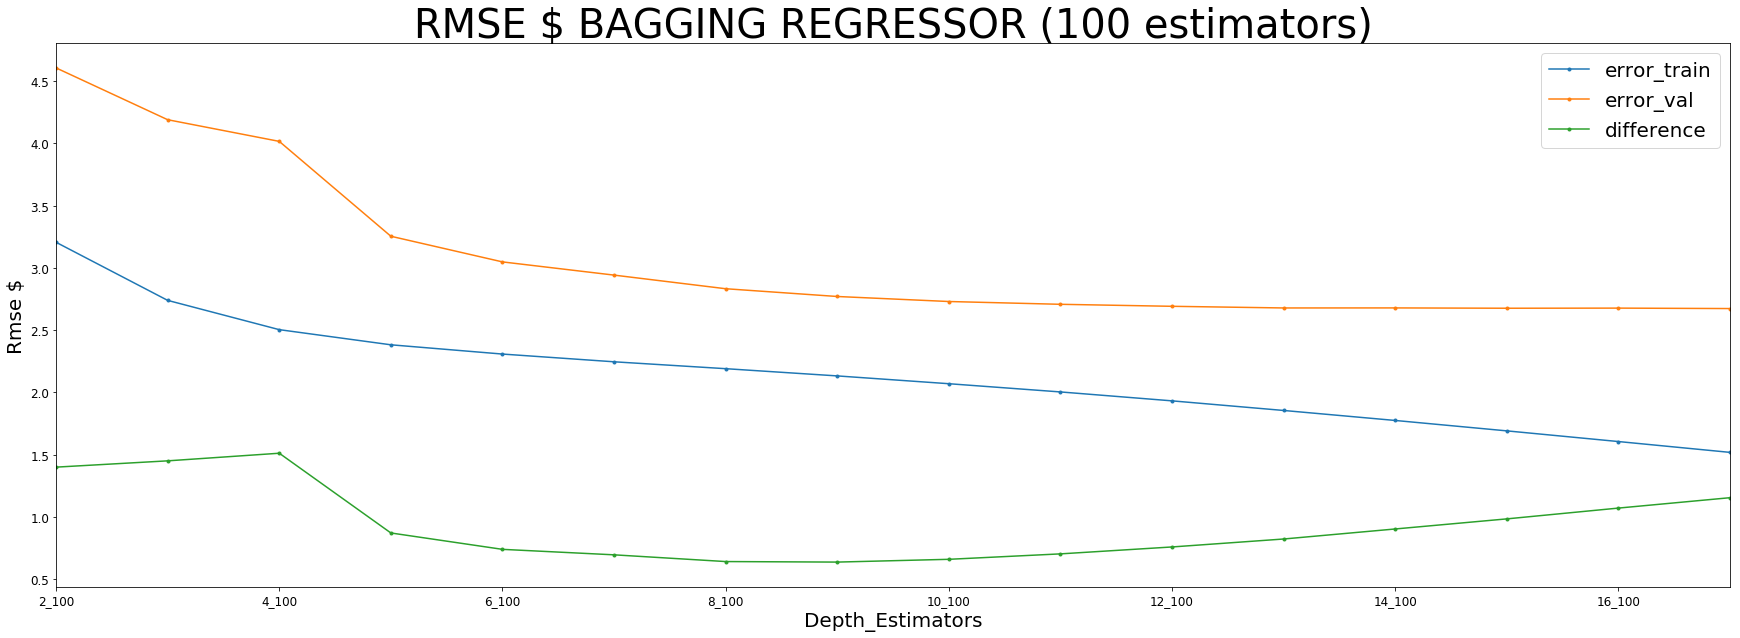

In [40]:
# We plot the results
ax = bg_df.plot(kind='line', style='.-',figsize=(30, 10),fontsize=14, rot=0)
ax.set_title('RMSE $ BAGGING REGRESSOR (100 estimators)', fontsize=40)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

The optimum depth for a Bagging Regressor + Decision Tree would be 10 based on the the difference between errors because for more depth the validation error keeps going down and never reaches a minimum which would cause overfitting.

### 3.5 BAGGING REGRESSOR + XGBOOST

For this model we are going to test with a depth between 5 and 8 because for the Xgboost model we tested previously was the one with which we got the best results.

#### 3.5.1 Check the model

In [41]:
%%time
dicc_bg_xgb={}
estimator = 100
for depth in range(5,9):
    print('Depth: %d' % (depth))    
    
    # We train the model
    taxi_model_bg_xgb = BaggingRegressor(XGBRegressor(max_depth=depth,
                                                     learning_rate=0.1,
                                                     n_estimators=estimator,
                                                     n_jobs=-1,
                                                     seed=13),
                                        n_jobs= -1,
                                        random_state=13)
    
    # We fit the model
    taxi_model_bg_xgb.fit(train_predictors, train_target)

    # We predict train and validation
    train_predictions = taxi_model_bg_xgb.predict(train_predictors)
    val_predictions = taxi_model_bg_xgb.predict(validation_predictors)
    
    # We get the errors
    error_train = rmse(train_target, train_predictions)
    error_val = rmse(validation_target, val_predictions)
    difference = error_val - error_train
    
    # We save the errors and the difference in a dictionary
    dicc_bg_xgb[str(depth) + '_' + str(estimator)]= [error_train,error_val,difference]
    
    print ('For a %d depth and %d estimators the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
            % (depth,estimator,error_train,error_val,difference))

Depth: 5
For a 5 depth and 100 estimators the RMSE_train is 2.12494 $, the RMSE_val is 2.52493 $ and the difference 0.39999 $
Depth: 6


/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For a 6 depth and 100 estimators the RMSE_train is 2.07021 $, the RMSE_val is 2.51874 $ and the difference 0.44852 $
Depth: 7


/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For a 7 depth and 100 estimators the RMSE_train is 2.00663 $, the RMSE_val is 2.51926 $ and the difference 0.51262 $
Depth: 8


/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For a 8 depth and 100 estimators the RMSE_train is 1.93983 $, the RMSE_val is 2.55918 $ and the difference 0.61935 $
CPU times: user 4.94 s, sys: 3.45 s, total: 8.39 s
Wall time: 1h 15min 36s


#### 3.5.2 Check the best depth 

In [42]:
# Best depth based on minimum error based on train data
min(dicc_bg_xgb.items(), key=lambda x: x[1][0])

('8_100', [1.9398270229299088, 2.559177946398303, 0.619350923468394])

In [43]:
# Best depth based on minimum error based on validation data
min(dicc_bg_xgb.items(), key=lambda x: x[1][1])

('6_100', [2.0702131150735474, 2.5187356810714596, 0.4485225659979122])

In [44]:
# Best depth based on difference of errors
min(dicc_bg_xgb.items(), key=lambda x: x[1][2])

('5_100', [2.124941334039914, 2.5249325904008493, 0.39999125636093513])

#### 3.5.3 Plot the errors and difference on the basis of the depth

In [45]:
# We convert the dictionary to Dataframe
bg_xgb_df = pd.DataFrame.from_dict(dicc_bg_xgb).T
bg_xgb_df.columns=['error_train','error_val','difference']
bg_xgb_df

,error_train,error_val,difference
5_100,2.124941,2.524933,0.399991
6_100,2.070213,2.518736,0.448523
7_100,2.006631,2.519255,0.512624
8_100,1.939827,2.559178,0.619351


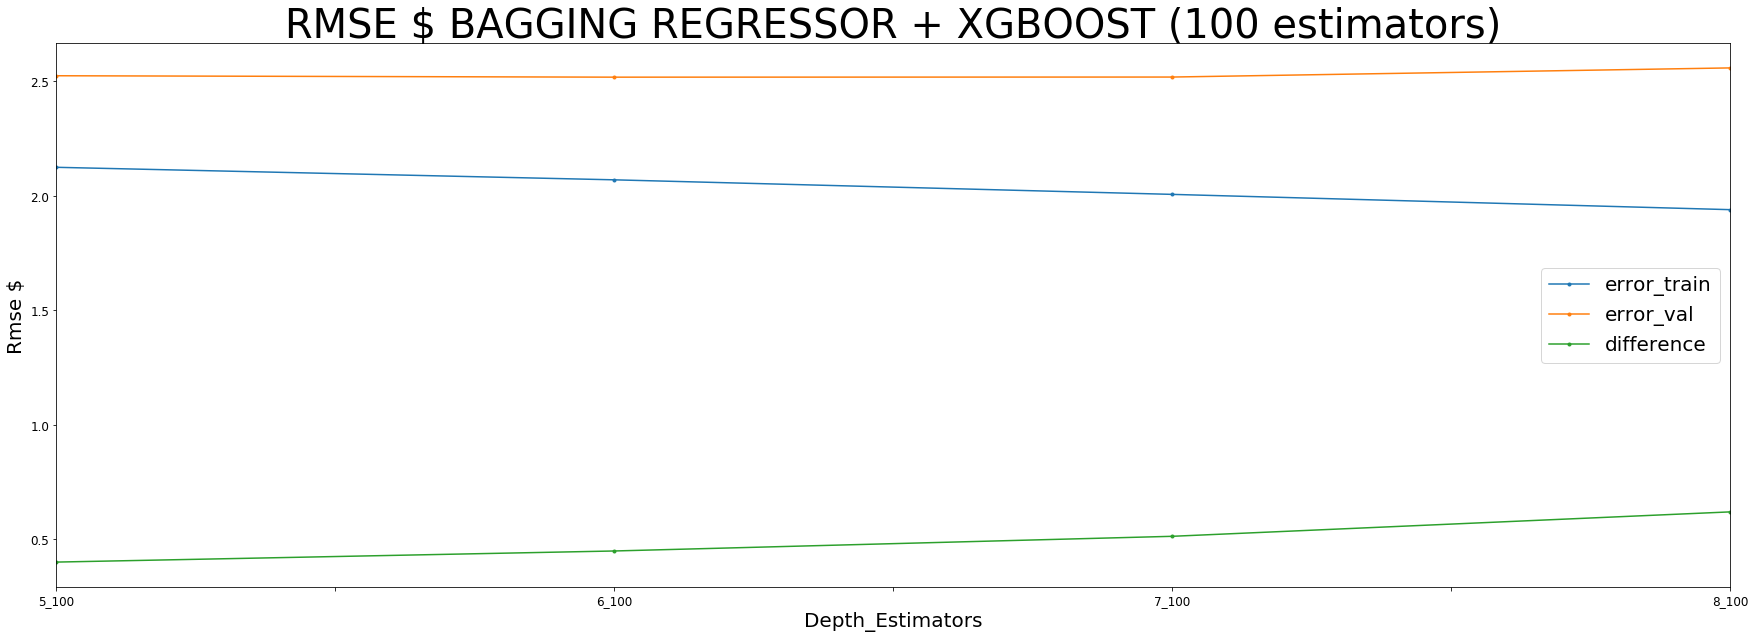

In [46]:
# We plot the results
ax = bg_xgb_df.plot(kind='line', style='.-',figsize=(30, 10),fontsize=12, rot=0)
ax.set_title('RMSE $ BAGGING REGRESSOR + XGBOOST (100 estimators)', fontsize=40)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

The optimum depth for a Bagging Regressor + Xgboost 5 based on the validation error and the difference between errors because more depth would cause overfitting.

### 3.6 Delete variables stored in memory

We eliminate the variables stored in memory that we are not going to use from now on to free up space.

In [47]:
del bg_df, bg_xgb_df, depth, dicc_bg, dicc_bg_xgb, dicc_dt, dicc_rf, dicc_xgb, difference, dt_df, error_train,\
error_val, estimator, rf_df, taxi_model_bg, taxi_model_bg_xgb, taxi_model_dt, taxi_model_rf, taxi_model_xgb, xgb_df

Based on the 5 models tested, we will choose the number of estimators for a model Bagging Regressor + Xgboost with depth 5 that is the best result obtained.

## 4 Check the chosen model and chose max estimators

### BAGGING REGRESSOR + XGBOOST with depth 5

Starting from the chosen model: Bagging + Xgboost with a depth of 5 we are going to choose the number of estimators.

### 4.1 Check the model

In [48]:
%%time
dicc_bg_xgb={}
for depth in range(5,6):
    print('Depth: %d' % (depth))
    for estimator in range(10,141,10):
        
        # We train the model
        taxi_model_bg_xgb = BaggingRegressor(XGBRegressor(max_depth=depth,
                                                          learning_rate=0.1,
                                                          n_estimators=estimator,
                                                          n_jobs=-1,
                                                          seed=13),
                                             n_jobs= -1,
                                             random_state=13)
        
        # We fit the model
        taxi_model_bg_xgb.fit(train_predictors, train_target)
        
        # We predict train and validation
        train_predictions = taxi_model_bg_xgb.predict(train_predictors)
        val_predictions = taxi_model_bg_xgb.predict(validation_predictors)
        
        # We get the errors
        error_train = rmse(train_target, train_predictions)
        error_val = rmse(validation_target, val_predictions)
        difference = error_val - error_train
        
        # We save the errors and the difference in a dictionary
        dicc_bg_xgb[str(depth) + '_' + str(estimator)]= [error_train,error_val,difference]
        
        print ('For a %d depth and %d estimators the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
            % (depth,estimator,error_train,error_val,difference))
        

Depth: 5
For a 5 depth and 10 estimators the RMSE_train is 6.01706 $, the RMSE_val is 8.09621 $ and the difference 2.07916 $
For a 5 depth and 20 estimators the RMSE_train is 3.00056 $, the RMSE_val is 4.32464 $ and the difference 1.32408 $


/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For a 5 depth and 30 estimators the RMSE_train is 2.34634 $, the RMSE_val is 3.10498 $ and the difference 0.75864 $
For a 5 depth and 40 estimators the RMSE_train is 2.22710 $, the RMSE_val is 2.74743 $ and the difference 0.52033 $
For a 5 depth and 50 estimators the RMSE_train is 2.19327 $, the RMSE_val is 2.63071 $ and the difference 0.43744 $
For a 5 depth and 60 estimators the RMSE_train is 2.17412 $, the RMSE_val is 2.57977 $ and the difference 0.40565 $


/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For a 5 depth and 70 estimators the RMSE_train is 2.15732 $, the RMSE_val is 2.55719 $ and the difference 0.39987 $


/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For a 5 depth and 80 estimators the RMSE_train is 2.14436 $, the RMSE_val is 2.54244 $ and the difference 0.39808 $
For a 5 depth and 90 estimators the RMSE_train is 2.13375 $, the RMSE_val is 2.53252 $ and the difference 0.39877 $
For a 5 depth and 100 estimators the RMSE_train is 2.12494 $, the RMSE_val is 2.52493 $ and the difference 0.39999 $


/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For a 5 depth and 110 estimators the RMSE_train is 2.11725 $, the RMSE_val is 2.51916 $ and the difference 0.40191 $


/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For a 5 depth and 120 estimators the RMSE_train is 2.11045 $, the RMSE_val is 2.51431 $ and the difference 0.40386 $
For a 5 depth and 130 estimators the RMSE_train is 2.10407 $, the RMSE_val is 2.51038 $ and the difference 0.40631 $


/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For a 5 depth and 140 estimators the RMSE_train is 2.09868 $, the RMSE_val is 2.50761 $ and the difference 0.40893 $
CPU times: user 15.9 s, sys: 10.2 s, total: 26.1 s
Wall time: 2h 16min 18s


### 4.2 Check the best depth 

In [49]:
# Best depth based on minimum error based on train data
min(dicc_bg_xgb.items(), key=lambda x: x[1][0])

('5_140', [2.09868057241416, 2.5076058192100925, 0.40892524679593256])

In [50]:
# Best depth based on minimum error based on validation data
min(dicc_bg_xgb.items(), key=lambda x: x[1][1])

('5_140', [2.09868057241416, 2.5076058192100925, 0.40892524679593256])

In [51]:
# Best depth based on difference of errors
min(dicc_bg_xgb.items(), key=lambda x: x[1][2])

('5_80', [2.1443628379426194, 2.5424398419022207, 0.3980770039596013])

### 4.3 Plot the errors and difference on the basis of the estimators

In [52]:
# We convert the dictionary to Dataframe
bg_xgb_df = pd.DataFrame.from_dict(dicc_bg_xgb).T
bg_xgb_df.columns=['error_train','error_val','difference']
bg_xgb_df

,error_train,error_val,difference
5_10,6.017057,8.096214,2.079157
5_20,3.000561,4.324643,1.324082
5_30,2.346342,3.104982,0.758639
5_40,2.227097,2.747430,0.520333
5_50,2.193268,2.630708,0.437440
5_60,2.174118,2.579768,0.405650
5_70,2.157319,2.557193,0.399873
5_80,2.144363,2.542440,0.398077
5_90,2.133750,2.532517,0.398768
5_100,2.124941,2.524933,0.399991


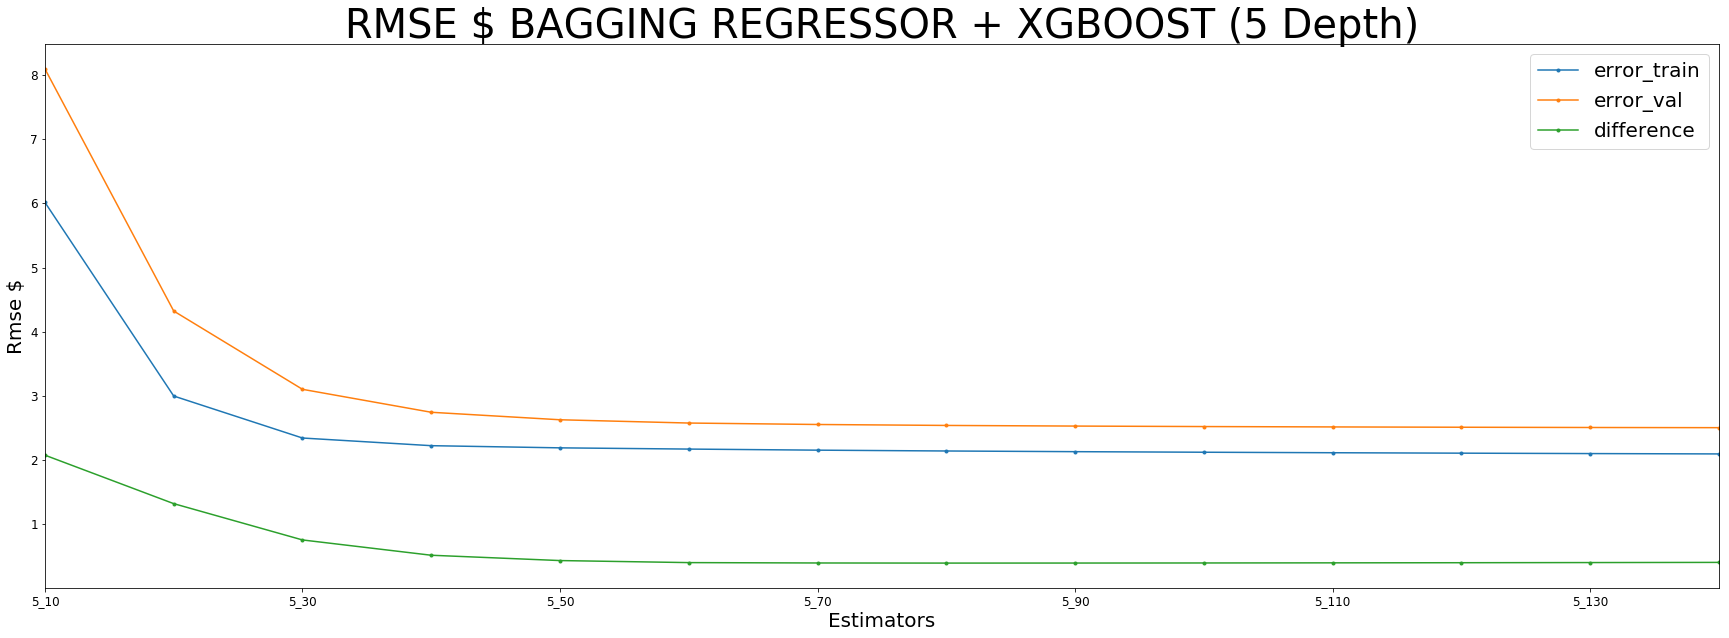

In [53]:
# We plot the results
ax = bg_xgb_df.plot(kind='line', style='.-',figsize=(30, 10),fontsize=12, rot=0)
ax.set_title('RMSE $ BAGGING REGRESSOR + XGBOOST (5 Depth)', fontsize=40)
ax.set_xlabel("Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

Based on this last analysis we have already found the best hyperparameters so we will now try to predict for a Bagging Regressor + Xgboost model with depth 5 and 120 estimators.

## 5 Bagging + Xgboost with depth 5 and 120 estimators sample dataset

Let's measure below how good our model is by predicting the test data fares  that we separate at the beginning of the notebook.

In [54]:
%%time

depth = 5
estimator = 120
print('Starting to train at %s' %(datetime.now()))
taxi_model_bg_xgb = BaggingRegressor(XGBRegressor(max_depth=depth,
                                                  learning_rate=0.1,
                                                  n_estimators=estimator,
                                                  n_jobs=-1,
                                                  seed=13),
                                     n_jobs= -1,
                                     random_state=13)
print('Finished train at %s' %(datetime.now()))

print('Starting to fit at %s' %(datetime.now()))
taxi_model_bg_xgb.fit(train_predictors, train_target)
print('Finished fit at %s' %(datetime.now()))

print('Starting to predict at %s' %(datetime.now()))
train_predictions = taxi_model_bg_xgb.predict(train_predictors)
val_predictions = taxi_model_bg_xgb.predict(validation_predictors)
test_predictions = taxi_model_bg_xgb.predict(test_predictors)
print('Finished predict at %s' %(datetime.now()))

error_train = rmse(train_target, train_predictions)
error_val = rmse(validation_target, val_predictions)
error_test = rmse(test_target, test_predictions)
difference = error_val - error_train
    
print ('For a %d depth and %d estimators the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
        % (depth,estimator,error_train,error_val,difference))

print ('For a %d depth and %d estimators the RMSE_test is %.5f $'
        % (depth, estimator, error_test))


Starting to train at 2019-05-16 07:34:45.119098
Finished train at 2019-05-16 07:34:45.121062
Starting to fit at 2019-05-16 07:34:45.121114
Finished fit at 2019-05-16 07:47:39.921083
Starting to predict at 2019-05-16 07:47:39.921665


/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Finished predict at 2019-05-16 07:47:52.237383
For a 5 depth and 120 estimators the RMSE_train is 2.11045 $, the RMSE_val is 2.51431 $ and the difference 0.40386 $
For a 5 depth and 120 estimators the RMSE_test is 2.59997 $
CPU times: user 1.18 s, sys: 738 ms, total: 1.92 s
Wall time: 13min 7s


## 6 Conclusion

After this analysis that has allowed us to choose the model that best suits the data and its hyperparameters, we have tested it with our data test and we have obtained an RMSE of $2.60.

Now what we are going to do is to test this model with the complete dataset in the notebook `final_eda.ipynb`

## 7 Save the model in a pickle

In [55]:
import pickle
# Dump the trained decision tree classifier with Pickle
bagging_xgb_pkl_filename = 'bagging_xgboost_d5_es120.pkl'
# Open the file to save as pkl file
bagging_xgb_pkl = open(bagging_xgb_pkl_filename, 'wb')
pickle.dump(taxi_model_bg_xgb, bagging_xgb_pkl)
# Close the pickle instances
bagging_xgb_pkl.close()